# <font color='violet'>Early Exploration</font>

This very early eda builds on instacart order data wrangled here: 
https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/Wrangling.ipynb

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import itertools
import matplotlib.lines as mlines

from library.sb_utils import save_file

In [2]:
df = pd.read_csv('../data/processed/full_data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_by_user_sequence  int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_sequence    int64  
 8   reordered               int64  
 9   product_name            object 
 10  aisle_name              object 
 11  dept_name               object 
 12  aisle_id                int64  
 13  department_id           int64  
 14  eval_set                object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


**<font color='violet'>Early Questions: What portion of users have reordered items? What ratio of all orders are reorders?</font>**

In [3]:
reorders = df[df['reordered']==1]
users_w_reorders = reorders['user_id'].unique()
portion_users_reorder = len(users_w_reorders) / len(df['user_id'].unique())
portion_users_reorder

0.9907860471657396

In [4]:
# Not for prediction, but to get a general sense of the data: What portion of items in any 
# carts are reorders?

reorder_rate = len(reorders) / len(df)
reorder_rate

0.5900617242809434

In [5]:
# Which products are ordered & reordered most? Reordered at the highest rate?

product_order_quantity = df.groupby('product_name')['product_name'].size()
product_order_quantity.sort_values(ascending=False)

product_name
Banana                                           491291
Bag of Organic Bananas                           394930
Organic Strawberries                             275577
Organic Baby Spinach                             251705
Organic Hass Avocado                             220877
                                                  ...  
Greek Blended Cherry Fat Free Yogurt                  1
All Natural Stevia Liquid Extract Sweetener           1
Frittata, Farmer's Market                             1
Max White With Polishing Star Soft Toothbrush         1
Orange Recharge                                       1
Name: product_name, Length: 49685, dtype: int64

In [6]:
product_reorder_quantity = reorders.groupby('product_name')[
    'product_name'].size()
product_reorder_quantity.sort_values(ascending=False)

product_name
Banana                                               415166
Bag of Organic Bananas                               329275
Organic Strawberries                                 214448
Organic Baby Spinach                                 194939
Organic Hass Avocado                                 176173
                                                      ...  
Raspberry Cheesecake                                      1
Liquid Vitamin B-Complex Natural Tangerine Flavor         1
Oktoberfest Malt Liquor                                   1
Gluten Free Potato Cracker Thins                          1
Black Professional Electrical Tape                        1
Name: product_name, Length: 45603, dtype: int64

In [7]:
product_reorder_rate = product_reorder_quantity / product_order_quantity
product_reorder_rate.sort_values(ascending=False)

product_name
Raw Veggie Wrappers                                           0.942029
Serenity Ultimate Extrema Overnight Pads                      0.933333
Orange Energy Shots                                           0.923077
Chocolate Love Bar                                            0.921569
Soy Powder Infant Formula                                     0.914286
                                                                ...   
Zipper Quart Size Freezer Bags                                     NaN
Ziti Rigate Penne                                                  NaN
Zyflamend Whole Body Liquid Vcaps                                  NaN
flings! Laundry Detergent Pacs, Original, 57 Count Laundry         NaN
flings! Original Laundry Detergent Pacs                            NaN
Name: product_name, Length: 49685, dtype: float64

NaN is for the products that never got reordered (reomoved from reorders df already). I could eventually try only bothering with items above a certain reorder threshold. Repeat this inspection of reorder proportions for aisles and departments.

**<font color='violet'>Inspect aisles and departments</font>**

In [8]:
aisle_order_quantity = df.groupby('aisle_name')['aisle_name'].size()
aisle_reorder_quantity = reorders.groupby('aisle_name')['aisle_name'].size()
aisle_reorder_rate = aisle_reorder_quantity / aisle_order_quantity

dept_order_quantity = df.groupby('dept_name')['dept_name'].size()
dept_reorder_quantity = reorders.groupby('dept_name')['dept_name'].size()
dept_reorder_rate = dept_reorder_quantity / dept_order_quantity

aisle_reorder_rate.sort_values(ascending=False)

aisle_name
milk                             0.781812
water seltzer sparkling water    0.729930
fresh fruits                     0.718823
eggs                             0.706359
soy lactosefree                  0.692361
                                   ...   
beauty                           0.212858
first aid                        0.195864
kitchen supplies                 0.194802
baking supplies decor            0.167595
spices seasonings                0.152933
Name: aisle_name, Length: 134, dtype: float64

In [9]:
dept_reorder_rate.sort_values(ascending=False)

dept_name
dairy eggs         0.670161
beverages          0.653651
produce            0.650521
bakery             0.628381
deli               0.608130
pets               0.602557
babies             0.577680
bulk               0.577090
snacks             0.574464
alcohol            0.571221
meat seafood       0.568625
breakfast          0.561351
frozen             0.542634
dry goods pasta    0.462220
canned goods       0.458639
other              0.407052
household          0.403339
missing            0.394323
international      0.369682
pantry             0.347400
personal care      0.321863
Name: dept_name, dtype: float64

**<font color='violet'>How often are items reordered?</font>**

In [11]:
reordered_order_2 = reorders[reorders['order_by_user_sequence']==2]

portion_reordered_immediately = len(reordered_order_2) / len(df[df['order_by_user_sequence']==1])
portion_reordered_immediately

0.26846330341451774

In [12]:
reordered_order_3 = reorders[reorders['order_by_user_sequence']==3]
print(len(reordered_order_2), len(reordered_order_3))

557885 792161


In [16]:
reordered_2_and_3 = reordered_order_2.merge(reordered_order_3, on='user_item')
len(reordered_2_and_3)

274487

In [17]:
portion_reordered_2_and_3 = len(reordered_2_and_3) / len(df[df['order_by_user_sequence']==1])
portion_reordered_2_and_3

0.13208759289878869

In [18]:
# What portion of items that were reordered in order 2 also got reordered in order 3?

portion_reordered_2_and_3 / portion_reordered_immediately

0.4920135870295849

About a quarter of items that were ordered in any given user's 1st order got reordered in their 2nd. Of items that got reordered immediately, about half were reordered again in their 3rd order. Later, do more to analyze reorder rates throughout the order sequence. 

**<font color='violet'>What is the pattern of reorders by weekday, time, and days since prior order?</font>**

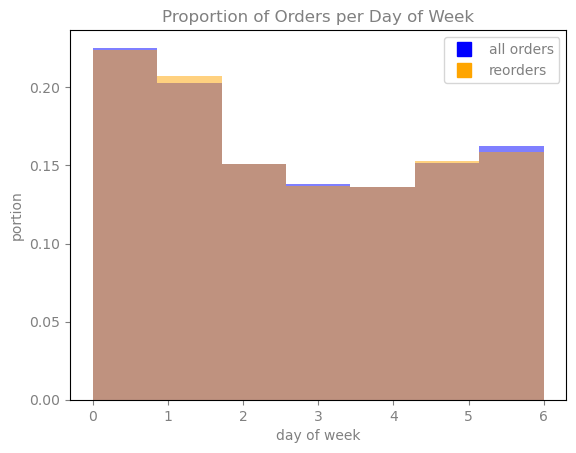

In [15]:
plt.hist(df['order_dow'], color='blue', density=True, alpha=0.5, bins=7)
plt.hist(reorders['order_dow'], color='orange', density=True, alpha=0.5, bins=7)
plt.title('Proportion of Orders per Day of Week')
plt.xlabel('day of week')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                     label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

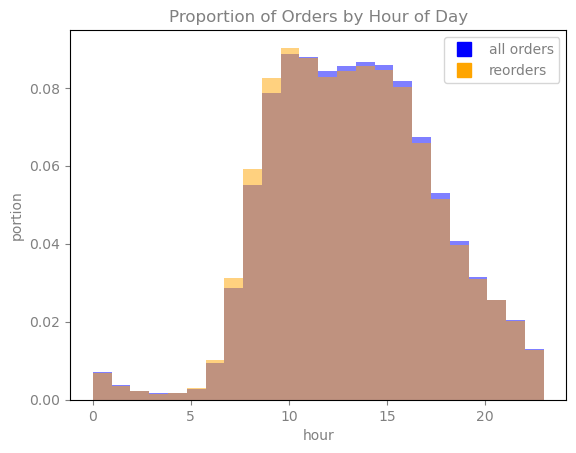

In [16]:
# Reorders don't seem much more likely overall any given day of the week. 

plt.hist(df['order_hour_of_day'], color='blue', density=True, alpha=0.5, bins=24)
plt.hist(reorders['order_hour_of_day'], color='orange', density=True, alpha=0.5, bins=24);
plt.title('Proportion of Orders by Hour of Day')
plt.xlabel('hour')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

I have no idea if this is a meaningful difference because it looks quite small, but there could be something to explore with regards to reorders being more likely from 7-10am. For example, are there particular items that are popular to buy in the morning? 

In [18]:
df['days_since_prior_order'].max()

30.0

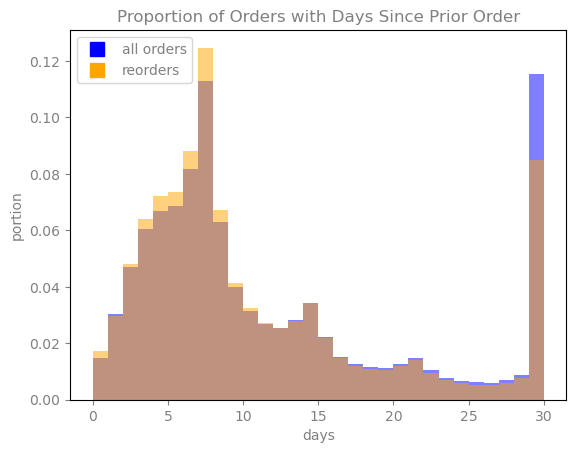

In [19]:
plt.hist(df['days_since_prior_order'], color='blue', density=True, alpha=0.5, bins=30)
plt.hist(reorders['days_since_prior_order'], color='orange', density=True, alpha=0.5, bins=30)
plt.title('Proportion of Orders with Days Since Prior Order')
plt.xlabel('days')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

It seems like more reorders happen when there have been under 10 days since the last order. I wonder if "30" here actually means "30 plus?" It's a weirdly big group. At any rate, reorders seem less likely when there's a longer time between orders. Could this be because more frequent shoppers get more of their staples via instacart? 

In [20]:
# Does an added_to_cart_sequence hist say anything?
df['add_to_cart_sequence'].max()

145

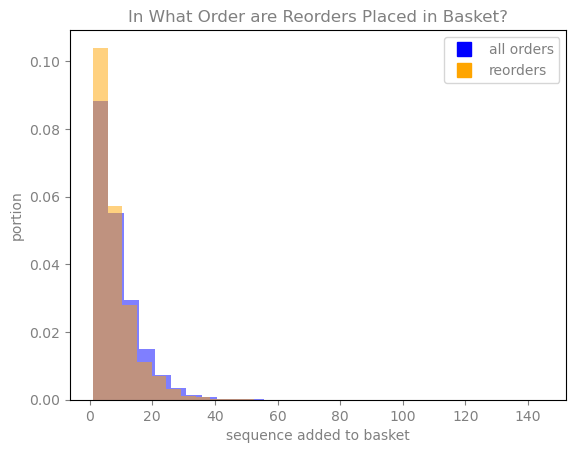

In [21]:
plt.hist(df['add_to_cart_sequence'], color='blue', density=True, alpha=0.5, bins=29)
plt.hist(reorders['add_to_cart_sequence'], color='orange', density=True, alpha=0.5, bins=29)
plt.title('In What Order are Reorders Placed in Basket?')
plt.xlabel('sequence added to basket')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

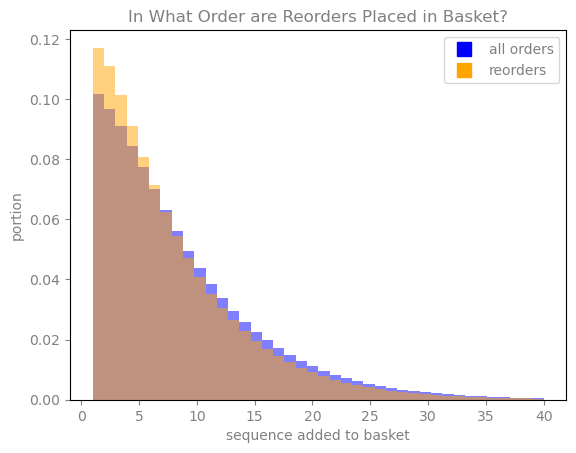

In [22]:
earlier_items_df = df[df['add_to_cart_sequence']<=40]
earlier_items_reorders = reorders[reorders['add_to_cart_sequence']<=40]

plt.hist(earlier_items_df['add_to_cart_sequence'], color='blue', density=True, alpha=0.5, 
         bins=40)
plt.hist(earlier_items_reorders['add_to_cart_sequence'], color='orange', density=True, alpha=0.5, 
         bins=40)
plt.title('In What Order are Reorders Placed in Basket?')
plt.xlabel('sequence added to basket')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

Items that are added to the cart earlier (up to item 6) are more often reorders. Or, to put it more accurately, I imagine, reorders are added to the cart earlier. Basics people know they want. I personally go throw staples in the cart as they run out and then place an order when I'm running too low on everything. Or maybe smaller orders are more likely to consist of reorders? Re-stocking just the basics. 

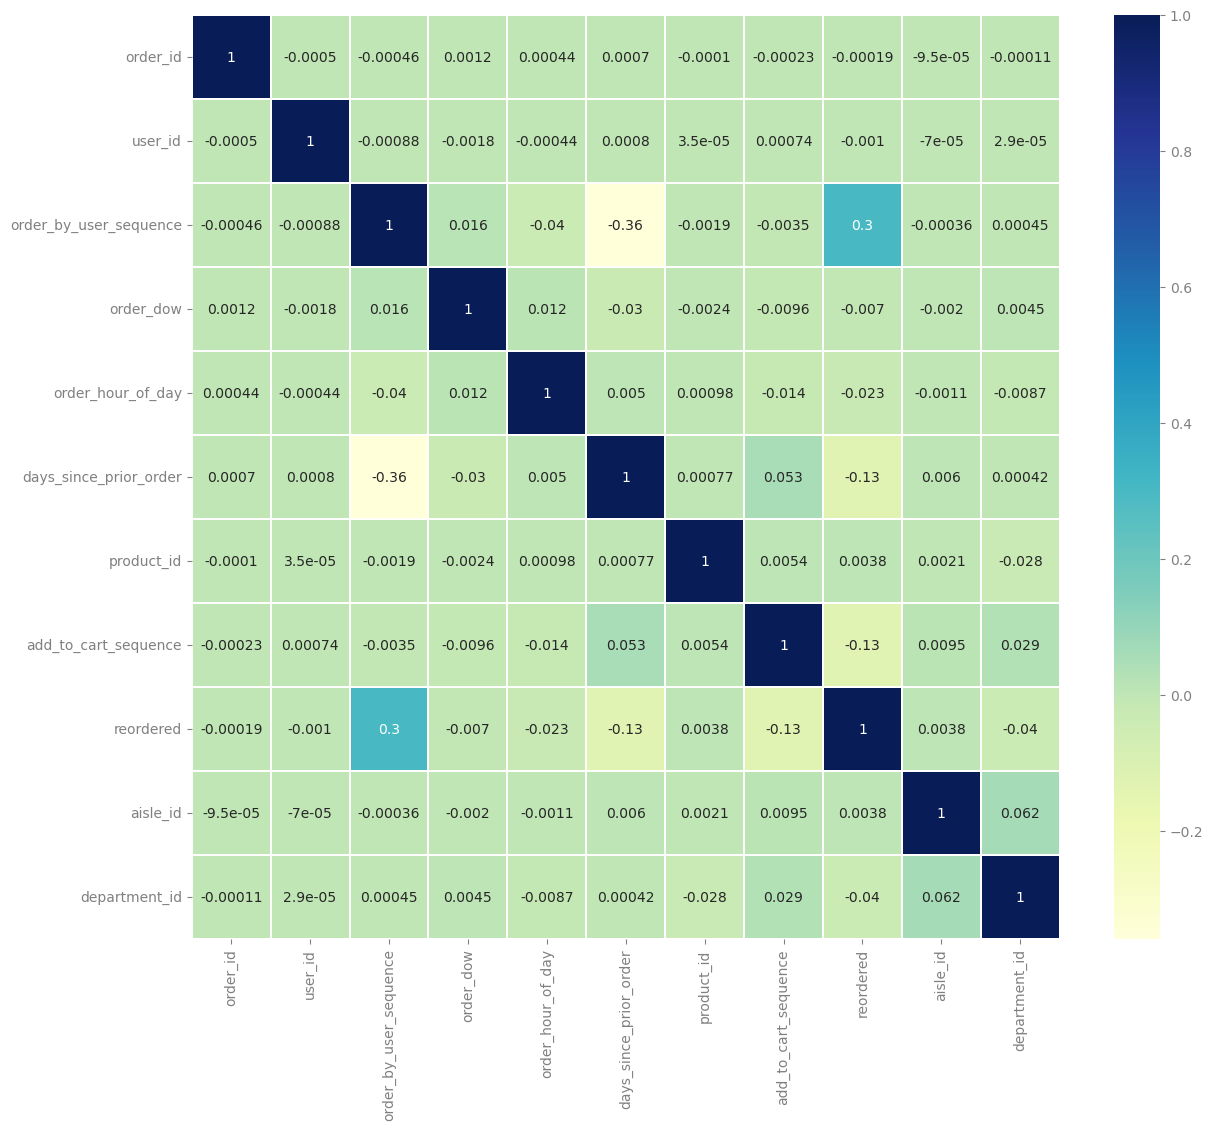

In [23]:
# Look at a correlation coefficient heatmap for all the columns. 
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

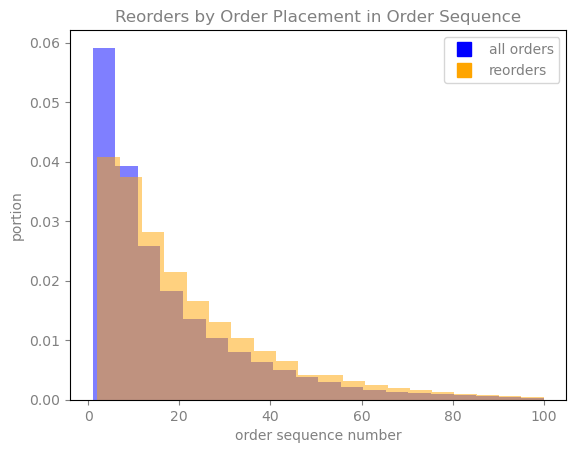

In [24]:
# There aren't many strong correlations with 'reordered.'. Explore more of the order sequence.
plt.hist(df['order_by_user_sequence'], color='blue', density=True, 
         alpha=0.5, bins=20)
plt.hist(reorders['order_by_user_sequence'], color='orange', 
         density=True, alpha=0.5, bins=20)
plt.title('Reorders by Order Placement in Order Sequence')
plt.xlabel('order sequence number')
plt.ylabel('portion')
blue = mlines.Line2D([], [], color='blue', marker='s', 
                       linestyle='None', markersize=10, 
                       label='all orders')
orange = mlines.Line2D([], [], color='orange', marker='s', 
                       linestyle='None', markersize=10, 
                       label='reorders')
plt.legend(handles=[blue, orange]);

I'd looked into the portion of items that were reordered in orders 2-3, but it makes sense that more items are reorders in later orders. This is kind-of obvious and possibly not super insightful. (The more items somebody has bought, the larger the group of items that could potentially be reorders) But, there could be predictions of which items get reordered, at what interval/sequence.

**<font color='violet'>Next Steps</font>**

Next: Analyze a single user's reorders. Going to move into a different notebook for that because this one will get too long and it's a slightly separate task. 

eda2 link: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda2_single_user.ipynb